# Udacity DeepLearning Project - Dog Classification

This notebook lists all the steps that you need to complete for this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

## Dog Classification

For this project we will use images of dogs to predict their respective dog breed. 
The data contains out of a pictures of a dog with it's corresponding dog breed. 
Using Deeplearning we will build a classifier capable of predicting the dog breed of a given dogs picture. 

More details about the data set and model building including optimalization can be found in this notebook

In [1]:
!pip install smdebug
!pip install bokeh

In [2]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import boto3
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Dataset
The dataset chosen for this project contains out images of dogs for 133 dog breeds.

#### Prepare data for exploration

In [4]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset = torchvision.datasets.ImageFolder(root='dogImages/train', transform=train_transform)
train_loader = DataLoader(train_dataset, 6, shuffle=True)
class_names = train_dataset.classes

# Get the number of classes
num_classes = len(train_dataset.classes)

# Get the number of images per class
num_images_per_class = {}
for class_name in train_dataset.classes:
    class_images = [img_path for img_path, class_idx in train_dataset.imgs if class_idx == train_dataset.class_to_idx[class_name]]
    num_images_per_class[class_name] = len(class_images)

class_names = []
class_num = []
for class_name, num_images in num_images_per_class.items():
    class_names.append(class_name)
    class_num.append(num_images)

data = {"Dog Breed": class_names, "Number of Dogs": class_num}
# To print out all Dog Breeds 
pd.set_option('display.max_rows', None) 
df = pd.DataFrame(data)

#### Number of dog breeds in training set

In [5]:
print("Number of dog breeds (class labels):", num_classes)

Number of dog breeds (class labels): 133


#### Total number of dog images in training set

In [6]:
print("Total number of dog images:", df['Number of Dogs'].sum())

Total number of dog images: 6680


#### Distribution of dog images by dog breed

In [7]:
df

,Dog Breed,Number of Dogs
0,001.Affenpinscher,64
1,002.Afghan_hound,58
2,003.Airedale_terrier,52
3,004.Akita,63
4,005.Alaskan_malamute,77
5,006.American_eskimo_dog,64
6,007.American_foxhound,50
7,008.American_staffordshire_terrier,66
8,009.American_water_spaniel,34
9,010.Anatolian_shepherd_dog,50


### Dog image examples

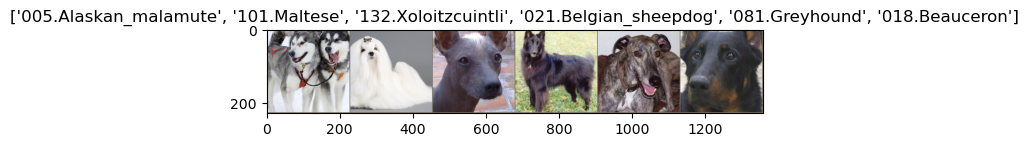

In [8]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#### Uploading data to S3

In [9]:
# Use the SageMaker Session to get the default bucket name
s3_bucket = sagemaker.Session().default_bucket()

print("S3 Default Bucket: {}".format(s3_bucket))

S3 Default Bucket: sagemaker-us-east-1-375855025888


In [42]:
# Upload to S3 
S3_BUCKET = 'sagemaker-us-east-1-375855025888'
subprocess.run(["aws", "s3", "sync", "./dogImages/train", f"s3://{S3_BUCKET}/train/"])
subprocess.run(["aws", "s3", "sync", "./dogImages/valid", f"s3://{S3_BUCKET}/valid/"])
subprocess.run(["aws", "s3", "sync", "./dogImages/test", f"s3://{S3_BUCKET}/test/"])

CompletedProcess(args=['aws', 's3', 'sync', './dogImages/test', 's3://sagemaker-us-east-1-375855025888/test/'], returncode=0)

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [12]:
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.01),
    "batch-size": CategoricalParameter([32, 64, 128]),
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

role = sagemaker.get_execution_role()

In [13]:
!pygmentize hpo.py

#TODO: Import your dependencies.
#For instance, below are some dependencies you might need if you are using Pytorch
# import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import argparse

import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


def test(model, test_loader, criterion, device):
    print("Testing Model on Whole Testing Dataset")
    model.eval()
    running_loss = 0
    running_corrects = 0

    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()

    test_loss = running_loss / len(test_loader.dataset)


In [14]:
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name="sagemaker-hpo-dog",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.large",
    framework_version="1.8",
    py_version="py36",
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [15]:
data_channels = {'train': 's3://sagemaker-us-east-1-375855025888/train', 'test': 's3://sagemaker-us-east-1-375855025888/test'}

In [16]:
tuner.fit(wait=True, inputs=data_channels)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.........................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [17]:
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2024-04-16 06:15:35 Starting - Preparing the instances for training
2024-04-16 06:15:35 Downloading - Downloading the training image
2024-04-16 06:15:35 Training - Training image download completed. Training in progress.
2024-04-16 06:15:35 Uploading - Uploading generated training model
2024-04-16 06:15:35 Completed - Resource reused by training job: pytorch-training-240416-0557-003-983d0adb


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"64"',
 'lr': '0.005712318974855285',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"sagemaker-hpo-dog-2024-04-16-05-57-50-625"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-375855025888/sagemaker-hpo-dog-2024-04-16-05-57-50-625/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [39]:
best_hyperparameters = {"epochs": "3", "batch-size": "64", "test-batch-size": "100", "lr": "0.005712318974855285"}

In [52]:
!pygmentize train_model.py

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import argparse
import smdebug.pytorch as smd
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


def test(model, test_loader, criterion, device):
    print("Testing Model on Whole Testing Dataset")
    running_loss = 0
    running_corrects = 0

    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects / len(test_loader.dataset)
    print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0

In [53]:
#https://aws.amazon.com/blogs/machine-learning/detecting-hidden-but-non-trivial-problems-in-transfer-learning-models-using-amazon-sagemaker-debugger/
from sagemaker.debugger import Rule, DebuggerHookConfig, rule_configs, ProfilerRule, CollectionConfig, ProfilerConfig, FrameworkProfile
loss_not_decreasing_rule = Rule.sagemaker(base_config=rule_configs.loss_not_decreasing(),
                             rule_parameters={"tensor_regex": "CrossEntropyLoss_output_0", "mode": "TRAIN"})

rules = [loss_not_decreasing_rule,
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

debugger_hook_config = DebuggerHookConfig(
      collection_configs=[ 
          CollectionConfig(
                name="custom_collection",
                parameters={ "include_regex": ".*ReLU_output|.*ResNet_input|.*image|.*CrossEntropyLoss",
                             "train.save_interval": "25",
                             "eval.save_interval": "25" })])

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [54]:
estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="sagemaker-dbpr-dog",
    role=get_execution_role(),
    hyperparameters=best_hyperparameters,
    instance_count=1,
    instance_type="ml.m5.large",
    framework_version="1.8",
    py_version="py36",
    ## Debugger parameters
    rules=rules,
    debugger_hook_config=debugger_hook_config,
    profiler_config=profiler_config,
)

In [55]:
data_channels = {
    'train': 's3://sagemaker-us-east-1-375855025888/train',
    'validation': 's3://sagemaker-us-east-1-375855025888/valid',
    'test': 's3://sagemaker-us-east-1-375855025888/test'
}

In [56]:
estimator.fit(wait=True, inputs=data_channels)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.i

2024-04-16 08:47:54 Starting - Starting the training job...
2024-04-16 08:48:18 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2024-04-16 08:48:47 Downloading - Downloading input data.........
2024-04-16 08:50:21 Downloading - Downloading the training image...
2024-04-16 08:50:48 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-04-16 08:50:48,985 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-04-16 08:50:48,989 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-04-16 08:50:48,998 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-04-16 08:50:49,002 sagemak

## Visualizing Debugger Output 

In [57]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2024-04-16 09:11:10.377 default:113 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-375855025888/sagemaker-dbpr-dog-2024-04-16-08-47-53-493/debug-output


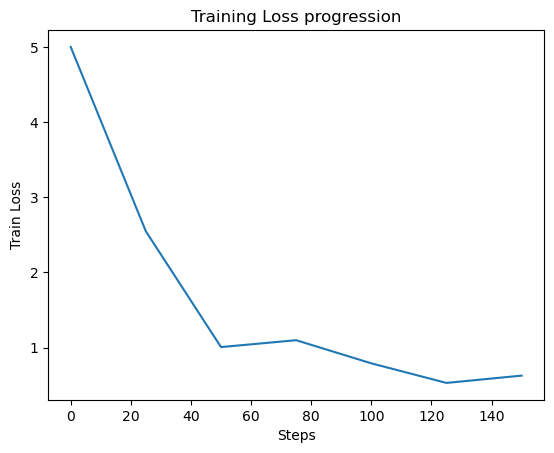

In [71]:
import matplotlib.pyplot as plt
plt.ylabel('Train Loss')
plt.xlabel('Steps')
plt.plot(trial.steps(mode=ModeKeys.TRAIN),
         list(trial.tensor('CrossEntropyLoss_output_0').values(mode=ModeKeys.TRAIN).values()))
plt.title('Training Loss progression')
plt.show()

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

### Download, open, and display the ProfilerReport HTML file

In [60]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [61]:
! aws s3 ls {rule_output_path} --recursive

2024-04-16 09:10:03     375656 sagemaker-dbpr-dog-2024-04-16-08-47-53-493/rule-output/ProfilerReport/profiler-output/profiler-report.html
2024-04-16 09:10:02     223587 sagemaker-dbpr-dog-2024-04-16-08-47-53-493/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2024-04-16 09:09:57        192 sagemaker-dbpr-dog-2024-04-16-08-47-53-493/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2024-04-16 09:09:57        200 sagemaker-dbpr-dog-2024-04-16-08-47-53-493/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2024-04-16 09:09:57       1973 sagemaker-dbpr-dog-2024-04-16-08-47-53-493/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2024-04-16 09:09:57        127 sagemaker-dbpr-dog-2024-04-16-08-47-53-493/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2024-04-16 09:09:57        199 sagemaker-dbpr-dog-2024-04-16-08-47-53-493/rule-output/ProfilerReport/profiler-outp

In [62]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-375855025888/sagemaker-dbpr-dog-2024-04-16-08-47-53-493/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-375855025888/sagemaker-dbpr-dog-2024-04-16-08-47-53-493/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-375855025888/sagemaker-dbpr-dog-2024-04-16-08-47-53-493/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-375855025888/sagemaker-dbpr-dog-2024-04-16-08-47-53-493/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json to ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json
download: s3://sagem

In [63]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [64]:
print(profiler_report_name)

ProfilerReport


#### Please see also pdf document with Debugger Profiling Report as part of project submission 

In [65]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [66]:
print("estimator model data location: ", estimator.model_data)

estimator model data location:  s3://sagemaker-us-east-1-375855025888/sagemaker-dbpr-dog-2024-04-16-08-47-53-493/output/model.tar.gz


In [67]:
from sagemaker.pytorch import PyTorchModel
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

In [68]:
!pygmentize inference.py

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import os
import io
import json
from PIL import Image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def net():
    model = models.resnet18(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    num_features = model.fc.in_features
    model.fc = nn.Sequential(
                   nn.Linear(num_features, 133))
    return model


def model_fn(model_dir):
    """Load saved model from file"""
    file_path = os.path.join(model_dir, "model.pth")
    model = net().to(device)
    model.load_state_dict(torch.load(file_path))
    model.eval()
    return model


# Define the transformation pipeline
img_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Define the 

In [69]:
# Create a PyTorchModel object
pytorch_model = PyTorchModel(
    model_data=estimator.model_data,
    role=get_execution_role(),
    entry_point='inference.py',  # Path to your PyTorch inference script
    framework_version='1.8.1',     # PyTorch version
    py_version="py36",
)

In [70]:
predictor = pytorch_model.deploy(
    instance_type='ml.m5.large',
    initial_instance_count=1,
    serializer=jpeg_serializer,
    deserializer=json_deserializer
)

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-375855025888/sagemaker-dbpr-dog-2024-04-16-08-47-53-493/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-375855025888/pytorch-inference-2024-04-16-09-23-27-578/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-04-16-09-23-32-393
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2024-04-16-09-23-33-152
INFO:sagemaker:Creating endpoint with name pytorch-inference-2024-04-16-09-23-33-152


------!

#### Prediction for an example

In [79]:
from PIL import Image
import io

# Open the image
image = Image.open("dogImages/test/020.Belgian_malinois/Belgian_malinois_01460.jpg")

# Create an in-memory byte buffer
image_bytes = io.BytesIO()

# Save the image to the byte buffer in JPEG format
image.save(image_bytes, format='JPEG')

# Get the bytes from the byte buffer
image_bytes.seek(0)
image = image_bytes.read()


response = predictor.predict(image, initial_args={'ContentType': 'image/jpeg'})


In [80]:
# The prediction should be matching the dogbreed subdirectory (label) in the test directory. e.g. 020.Belgian_malinois for Belgain Malinois images
import numpy as np
print(class_names[np.argmax(response, 1)[0]])

020.Belgian_malinois


#### Another example just for FUN!

In [81]:
# Open the image
image = Image.open("dogImages/test/016.Beagle/Beagle_01155.jpg")

# Create an in-memory byte buffer
image_bytes = io.BytesIO()

# Save the image to the byte buffer in JPEG format
image.save(image_bytes, format='JPEG')

# Get the bytes from the byte buffer
image_bytes.seek(0)
image = image_bytes.read()


response = predictor.predict(image, initial_args={'ContentType': 'image/jpeg'})


In [82]:
# The prediction should be matching the dogbreed subdirectory (label) in the test directory. e.g. 020.Belgian_malinois for Belgain Malinois images
import numpy as np
print(class_names[np.argmax(response, 1)[0]])

016.Beagle


In [83]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2024-04-16-09-23-33-152
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2024-04-16-09-23-33-152
